Clone the directory from https://github.com/milesial/Pytorch-UNet.git

<img src="img/Uecker1.jpg">

In [2]:
import sys
import os
from optparse import OptionParser
import numpy as np

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch import optim

from eval import eval_net
from unet import UNet
from utils import get_ids, split_ids, split_train_val, get_imgs_and_masks, batch

In [4]:
# Do not Run this cell
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return F.sigmoid(x)
# sub-parts of the U-Net model

import torch
import torch.nn as nn
import torch.nn.functional as F


class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [5]:
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg 
import sigpy.plot as pl
# im = Image.open('test.gif')
%matplotlib notebook

In [6]:
im_car = mpimg.imread('/mikQNAP/segmentation_cars/train_hq/00087a6bd4dc_01.jpg')
im_mask = mpimg.imread('/mikQNAP/segmentation_cars/train_masks/00087a6bd4dc_01_mask.gif')

In [7]:
im_car.shape

(1280, 1918, 3)

<IPython.core.display.Javascript object>


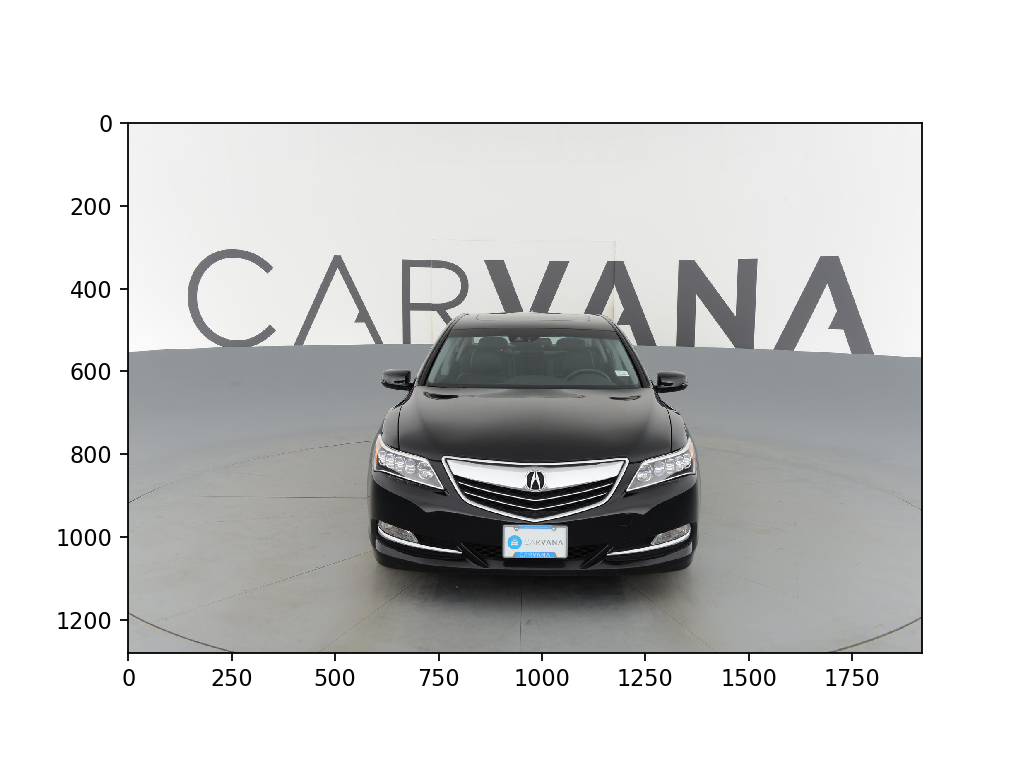

In [8]:
plt.imshow(im_car)

<IPython.core.display.Javascript object>


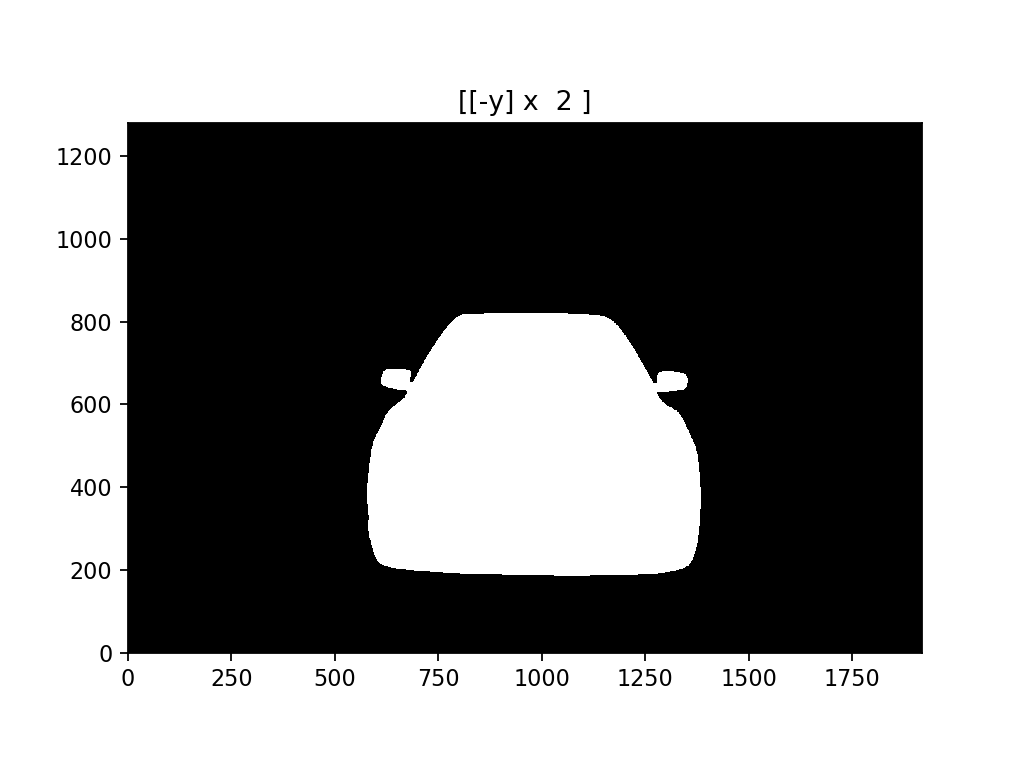

In [9]:
pl.Image(im_mask)

In [10]:
def train_net(net,
              epochs=5,
              batch_size=1,
              lr=0.1,
              val_percent=0.05,
              save_cp=True,
              gpu=False,
              img_scale=0.5):

    dir_img = '/mikQNAP/segmentation_cars/train_hq/'
    dir_mask = '/mikQNAP/segmentation_cars/train_masks/'
    dir_checkpoint = 'checkpoints_uecker/'

    ids = get_ids(dir_img)
    ids = split_ids(ids)

    iddataset = split_train_val(ids, val_percent)

    print('''
    Starting training:
        Epochs: {}
        Batch size: {}
        Learning rate: {}
        Training size: {}
        Validation size: {}
        Checkpoints: {}
        CUDA: {}
    '''.format(epochs, batch_size, lr, len(iddataset['train']),
               len(iddataset['val']), str(save_cp), str(gpu)))

    N_train = len(iddataset['train'])

    optimizer = optim.SGD(net.parameters(),
                          lr=lr,
                          momentum=0.9,
                          weight_decay=0.0005)

    criterion = nn.BCELoss()

    for epoch in range(epochs):
        print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
        net.train()

        # reset the generators
        train = get_imgs_and_masks(iddataset['train'], dir_img, dir_mask, img_scale)
        val = get_imgs_and_masks(iddataset['val'], dir_img, dir_mask, img_scale)

        epoch_loss = 0

        for i, b in enumerate(batch(train, batch_size)):
            imgs = np.array([i[0] for i in b]).astype(np.float32)
            true_masks = np.array([i[1] for i in b])

            imgs = torch.from_numpy(imgs)
            true_masks = torch.from_numpy(true_masks)

            if gpu:
                imgs = imgs.cuda()
                true_masks = true_masks.cuda()

            masks_pred = net(imgs)
            masks_probs_flat = masks_pred.view(-1)

            true_masks_flat = true_masks.view(-1)

            loss = criterion(masks_probs_flat, true_masks_flat)
            epoch_loss += loss.item()

            print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item()))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('Epoch finished ! Loss: {}'.format(epoch_loss / i))

        if 1:
            val_dice = eval_net(net, val, gpu)
            print('Validation Dice Coeff: {}'.format(val_dice))

        if save_cp:
            torch.save(net.state_dict(),
                       dir_checkpoint + 'CP{}.pth'.format(epoch + 1))
            print('Checkpoint {} saved !'.format(epoch + 1))

In [ ]:
#     args = get_args()

net = UNet(n_channels=3, n_classes=1)
net.cuda()

try:
    train_net(net=net,
              epochs=50,
              batch_size=1,
              lr=0.001,
              gpu=True,
              img_scale=1)
except KeyboardInterrupt:
    torch.save(net.state_dict(), 'INTERRUPTED.pth')
    print('Saved interrupt')
    try:
        sys.exit(0)
    except SystemExit:
        os._exit(0)



    Starting training:
        Epochs: 50
        Batch size: 1
        Learning rate: 0.001
        Training size: 9668
        Validation size: 508
        Checkpoints: True
        CUDA: True
    
Starting epoch 1/50.


/home/kewang/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/kewang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.0000 --- loss: 0.732714
0.0001 --- loss: 0.744347
0.0002 --- loss: 0.720307
0.0003 --- loss: 0.702192
0.0004 --- loss: 0.692935
0.0005 --- loss: 0.677132
0.0006 --- loss: 0.656669
0.0007 --- loss: 0.661045
0.0008 --- loss: 0.636987
0.0009 --- loss: 0.627022
0.0010 --- loss: 0.647820
0.0011 --- loss: 0.593558
0.0012 --- loss: 0.617071
0.0013 --- loss: 0.583454
0.0014 --- loss: 0.613481
0.0016 --- loss: 0.584441
0.0017 --- loss: 0.620419
0.0018 --- loss: 0.574091
0.0019 --- loss: 0.544161
0.0020 --- loss: 0.570744
0.0021 --- loss: 0.600769
0.0022 --- loss: 0.523255
0.0023 --- loss: 0.619283
0.0024 --- loss: 0.566861
0.0025 --- loss: 0.588150
0.0026 --- loss: 0.519675
0.0027 --- loss: 0.576031
0.0028 --- loss: 0.537062
0.0029 --- loss: 0.596269
0.0030 --- loss: 0.500988
0.0031 --- loss: 0.481560
0.0032 --- loss: 0.492064
0.0033 --- loss: 0.568280
0.0034 --- loss: 0.538894
0.0035 --- loss: 0.565941
0.0036 --- loss: 0.533220
0.0037 --- loss: 0.554649
0.0038 --- loss: 0.543894
0.0039 --- l